# 2.1 ML models using  Median Impute

In [70]:
# Reading the train and test dataset where missing values are imputed using median
train = pd.read_csv("Train_imputed_median")
test = pd.read_csv("test_imputed_median")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [71]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [72]:
train['class'] = y_train

In [73]:
#Undersampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [74]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [75]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
9,153204.0,182.0,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0,1
23,453236.0,2926.0,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0,1
60,72504.0,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0,1


In [76]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [77]:
# Upsampling the positive class using Smote Technique
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [78]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 160)


In [79]:
#Standardizing the data
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 2.1.1 Logistic Regression

In [16]:
# Defining the LR model and performing the hyper parameter tuning using gridsearch
#weights = np.linspace(0.05, 0.95, 20)
params = {'C' : [
                10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2']#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
         }

clf = LogisticRegression(n_jobs= -1,random_state=42)
clf.fit(train_std,y_train)
model = GridSearchCV(estimator=clf,cv = 2,n_jobs= -1,param_grid=params,scoring='f1',verbose= 2,)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:   40.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.3min finished


Best estimator is {'C': 1000, 'penalty': 'l2'}


In [50]:
# model fitting using the best parameter.
clf = LogisticRegression(n_jobs= -1,random_state=42,C= 1000,penalty= 'l2')
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15269   356]
 [   34   341]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  356
Type 2 error (False Negative) =  34
---------------------------------------------------------------------------------------------------------------------
Total cost =  20560
---------------------------------------------------------------------------------------------------------------------


- Lets try to reduce the total number of FN by adjusting the probability threshold.
- A best threshold is decided using cross validation to find the least cost. In this process we will end up finding the optimal values for FN and FP.

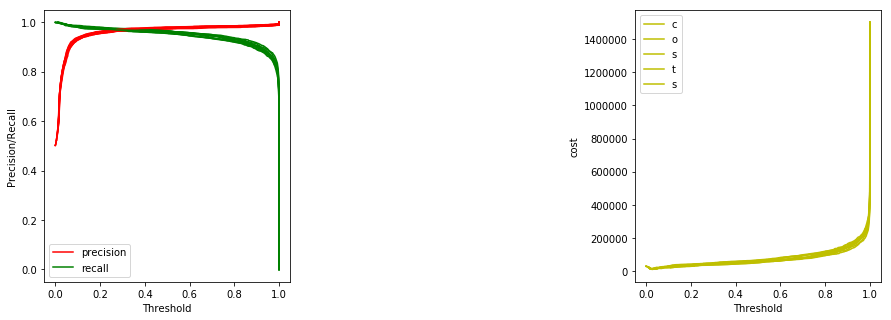

In [51]:
# Cross Validation to find the best threshold.
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    
# Plot of recall, precision v/s threshold and cost v/s threshold
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [52]:
# model fitting and finding the cost with best threshold.
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.2
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  657
Type 2 error (False Negative) =  24
---------------------------------------------------------------------------------------------------------------------
Total cost =  18570
---------------------------------------------------------------------------------------------------------------------


# 2.1.2 XgBoost

In [39]:
# model fitting and hyper parameter tuning to find the best parameter.
x_cfl=XGBClassifier()

prams={
    #'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    #'colsample_bytree':[0.1,0.3,0.5,1],
   # 'subsample':[0.1,0.3,0.5,1]
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 16.6min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 21.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 28.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 2000}


In [53]:
#model fitting with the best parameter.
clf = XGBClassifier(max_depth= 10,  n_estimators= 2000,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15446   179]
 [   34   341]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  179
Type 2 error (False Negative) =  34
---------------------------------------------------------------------------------------------------------------------
Total cost =  18790
---------------------------------------------------------------------------------------------------------------------


- Lets try to reduce the total number of FN by adjusting the probability threshold.
- A best threshold is decided using cross validation to find the least cost. In this process we will end up finding the optimal values for FN and FP.

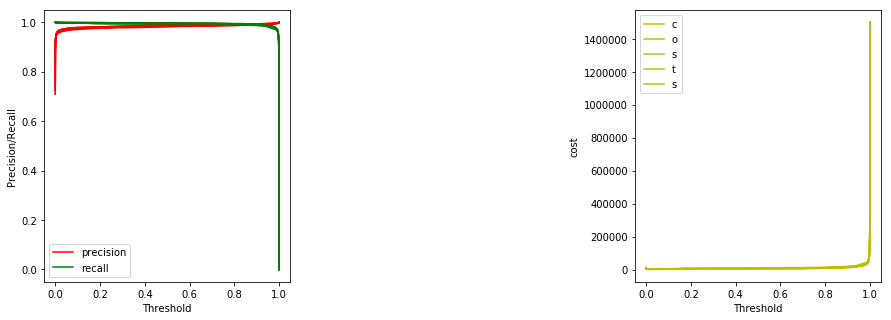

In [54]:
#Cv to find the best threshold to minimize the total cost.
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [43]:
#model fitting and predicting using the best threshold.
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  244
Type 2 error (False Negative) =  25
---------------------------------------------------------------------------------------------------------------------
Total cost =  14940
---------------------------------------------------------------------------------------------------------------------


# 2.1.3 Random Forest

In [42]:
# model fitting and hyperparamter tunning
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  4.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  6.8min remaining:   41.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.7min finished


Best estimator is {'max_depth': 10, 'n_estimators': 1000}


In [80]:
# model fitting using the best parameter and predicting the cost
clf = RandomForestClassifier(n_estimators= 1000 , max_depth=10,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15204   421]
 [   14   361]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  421
Type 2 error (False Negative) =  14
---------------------------------------------------------------------------------------------------------------------
Total cost =  11210
---------------------------------------------------------------------------------------------------------------------


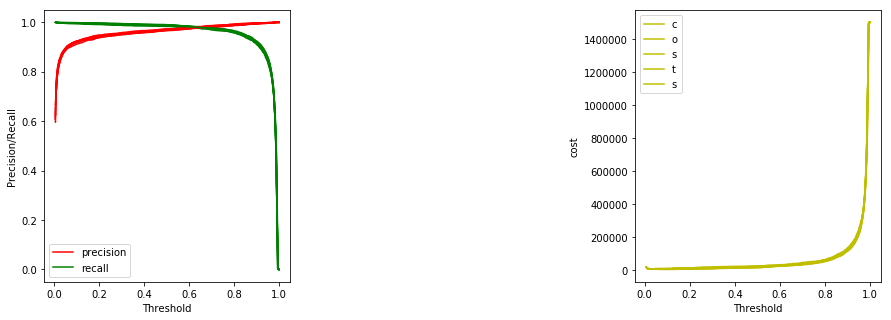

In [46]:
# CV to find the best threshold.
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [31]:
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  767
Type 2 error (False Negative) =  6
---------------------------------------------------------------------------------------------------------------------
Total cost =  10670
---------------------------------------------------------------------------------------------------------------------
